In [1]:
import sys
sys.path.insert(0, "../../../")

In [2]:
import deeplay as dtm
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torchvision
import pytorch_lightning as pl

In [3]:
# Load the MNIST dataset and normalize it to [-1, 1]

mnist = torchvision.datasets.MNIST(
    root="../../data", train=True, download=True, transform=torchvision.transforms.ToTensor()
)

mnist_test = torchvision.datasets.MNIST(
    root="../../data", train=False, download=True, transform=torchvision.transforms.ToTensor()
)

In [4]:
mnist_dataloader = torch.utils.data.DataLoader(mnist, batch_size=32, num_workers=4)
mnist_test_dataloader = torch.utils.data.DataLoader(mnist_test, batch_size=32, num_workers=4)

In [9]:
gan  = dtm.ClassConditionedGAN.from_config(
    dtm.Config()
    .hidden_dim(10)
    .discriminator.backbone.depth(3)
    .discriminator.backbone.blocks.populate("layer.out_channels", [64, 128, 256])
    .generator.backbone.generator.depth(3)
    .generator.backbone.blocks.layer(kernel_size=3, padding=1)
)
sample_image, sample_label = next(iter(mnist_dataloader))
gan.discriminate(sample_image, sample_label)
gan.generate(sample_label)
gan

ClassConditionedGAN(
  (hidden_dim): 10
  (generator): Template(
    (backbone): SpatialBroadcastDecoder2d(
      (depth): 4
      (output_size): torch.Size([28, 28])
      (input): Identity()
      (encoding): PositionalEncodingLinear2d()
      (blocks): ModuleList(
        (0): Template(
          (layer): Conv2d(16, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (1): Template(
          (layer): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (2): Template(
          (layer): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (3): Template(
          (layer): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
      )
    )
    (head): ImageRegressionHead(
      (num_outputs): 1
      (output): Template(
        (layer): Conv2d(128, 1, k

In [10]:

trainer = pl.Trainer(max_epochs=10, accelerator="auto")
trainer.fit(gan, mnist_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type                | Params
-----------------------------------------------------------
0 | generator          | Template            | 461 K 
1 | discriminator      | UninitializedModule | 374 K 
2 | embedding          | Embedding           | 40    
3 | discriminator_loss | BCELoss             | 0     
4 | generator_loss     | BCELoss             | 0     
-----------------------------------------------------------
835 K     Trainable params
0         Non-trainable params
835 K     Total params
3.343     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


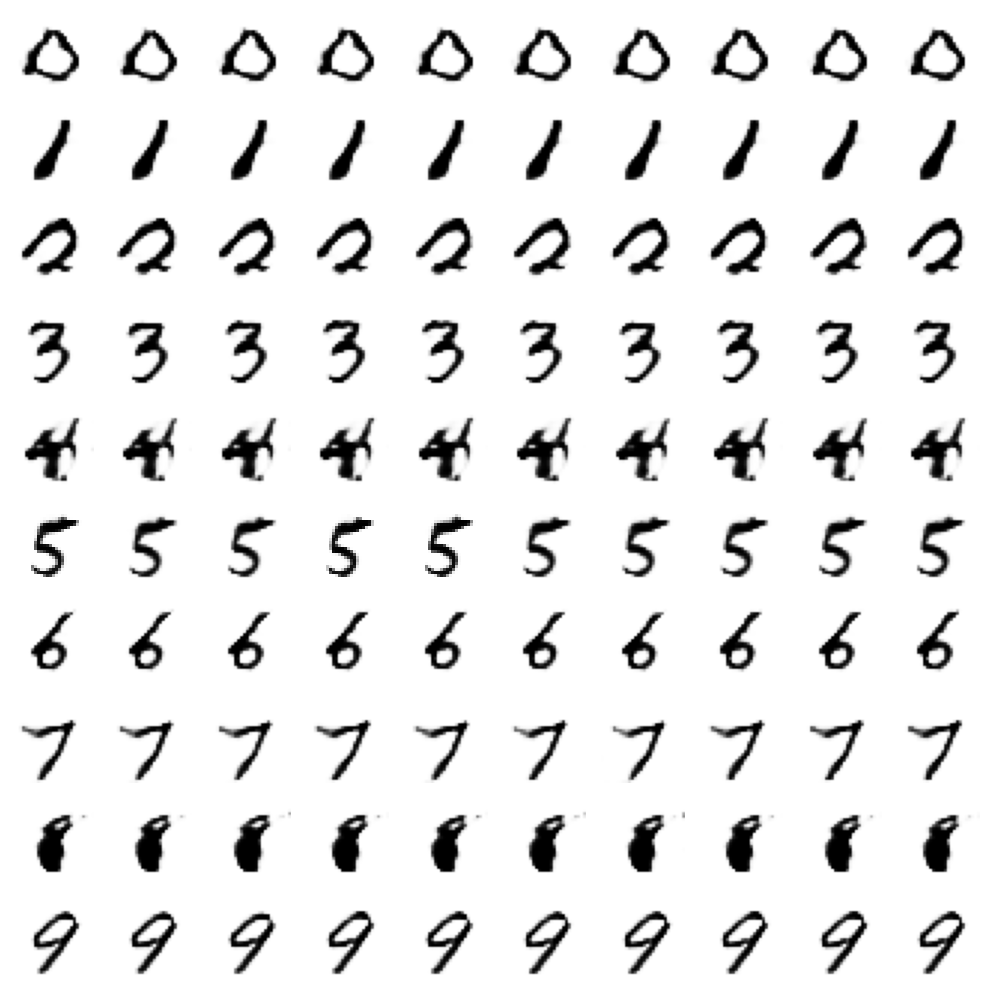

In [11]:

# plot a grid of generated images
import matplotlib.pyplot as plt
import numpy as np

n = 10
plt.figure(figsize=(10, 10))
for digit in range(10):
    for i in range(n):
        x = gan.generate(torch.tensor([digit] * n).long().to(gan.device))
        plt.subplot(n, 10, digit * n + i + 1)
        plt.imshow(x[0].detach().cpu().numpy().transpose((1, 2, 0)), cmap="Greys", vmin=0, vmax=1)
        plt.axis("off")

plt.tight_layout()
plt.show()